# Numba
### Accelerating a function with Numba

In [1]:
import math
import numpy as np
import numba

In [2]:
def simulate_tree(M: int):
    S0 = 36.
    T=1.0
    r=0.06
    sigma = 0.2

    dt=T/M
    u = math.exp(sigma * math.sqrt(dt))
    d=1/u
    S=np.zeros((M+1,M+1))
    S[0,0]=S0
    z=1
    for t in range(1, M + 1):
        for i in range(z):
            S[i, t] = S[i, t-1]*u
            S[i+1, t] = S[i, t-1] * d
        z+=1
    return S

In [3]:
simulate_tree_nb = numba.njit(simulate_tree)

In [4]:
%timeit simulate_tree(2000)

1.01 s ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%timeit simulate_tree_nb(2000)

4.15 ms ± 204 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Numba is over 300x faster (!) than pure Python

In [6]:
1290 / 4  # runtime in miliseconds

322.5

### Support for classes in Numba
(Still experimental)...

# Monte Carlo
### Option Pricing

In [7]:
import matplotlib.pyplot as plt

In [8]:
S0 = 36.0 # underlying price
r = 0.03  # interest rate
sigma = 0.2 # underyling volatitliy
T = 2.0   # num years
M = 100   # num steps
I = 50000 # num scenarios

In [9]:
@numba.njit
def mcs_simulation_py(M, I):
    dt=T/M
    S = np.zeros((M + 1, I))
    S[0] = S0
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1):
        for i in range(I):
            S[t, i] = S[t-1, i] * math.exp((r-sigma**2/2)*dt+sigma * math.sqrt(dt) * rn[t, i])
    return S

In [10]:
paths = mcs_simulation_py(1000, 100000)
Sn = paths[-1]

In [11]:
Sn

array([32.76494151, 37.53258672, 40.64340654, ..., 30.25154531,
       35.75693556, 33.67083172])

In [12]:
K = 40.0  # Option Strike Price
payoff = np.maximum(Sn - K, 0)

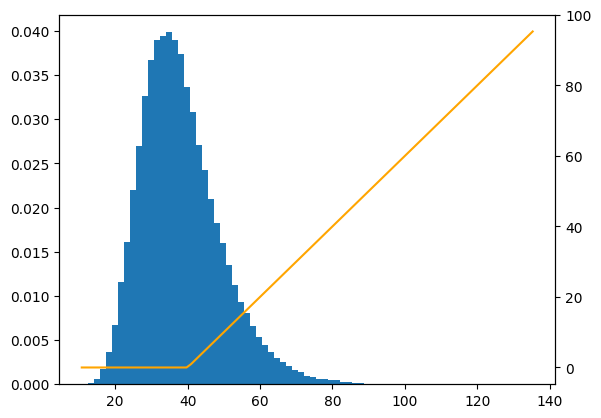

In [13]:
plt.hist(Sn, bins=75, density=True)
plt.twinx()
xs = np.linspace(Sn.min(), Sn.max(), 100)
ys = np.maximum(xs - K, 0)
plt.plot(xs, ys, color="orange")
plt.show()

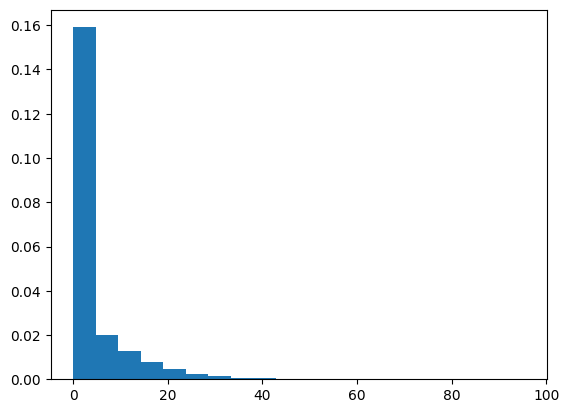

In [14]:
plt.hist(payoff, bins=20, density=True)
plt.show()

In [15]:
C0 = math.exp(- r * T) * payoff.mean()
C0

3.379649235746311

### Drawing samples straight from the Log-Normal distribution

In [16]:
from scipy.stats import lognorm

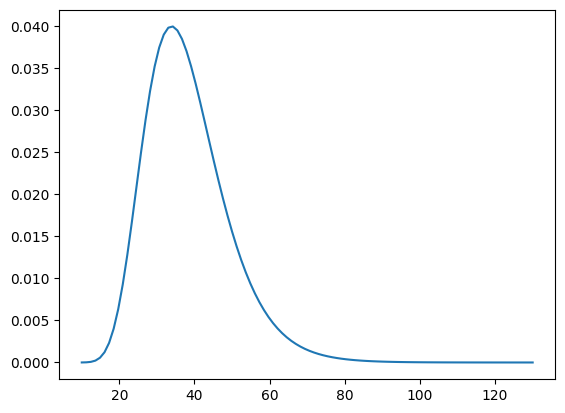

In [17]:
xs = np.linspace(10, 130, 100)

# Parameters for the log-normal distribution
mu_log = np.log(S0) + (r - (sigma**2) / 2) * T
sigma_log = sigma * np.sqrt(T)

# Create the log-normal distribution
rv = lognorm(scale=np.exp(mu_log), s=sigma_log)
ys = rv.pdf(xs)
plt.plot(xs, ys)
plt.show()

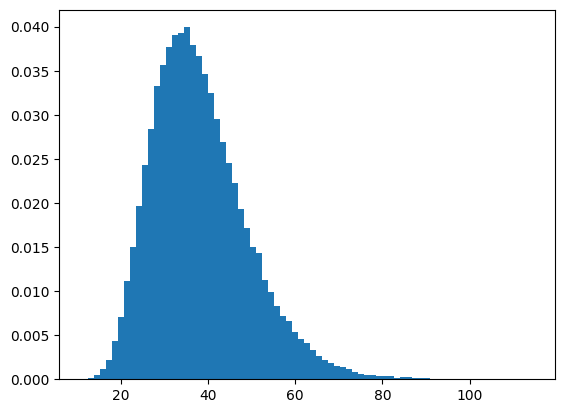

In [18]:
Sn_2 = rv.rvs(100000)
plt.hist(Sn_2, bins=75, density=True)
plt.show()

In [19]:
Sn.mean(), Sn_2.mean()

(38.24124542245058, 38.29326025938855)

In [20]:
Sn.std(), Sn_2.std()

(11.077745768394857, 11.053179621339611)

### Compute the option price with integration
We can see that the integration method comes closer to the black-scholes price.

In [21]:
xs = np.linspace(0, 150, 1000)
payoff = np.maximum(xs - K, 0)

In [22]:
np.trapz(payoff * rv.pdf(xs), xs)

3.567874805990943

In [23]:
np.maximum(Sn - K, 0).mean()

3.588635073019527

In [24]:
from scipy.stats import norm

def black_scholes():
    # Calculate d1 and d2
    d1 = (np.log(S0 / K) + (r + (sigma**2) / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    # Calculate the call option price
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

In [25]:
black_scholes() * np.exp(r*T)  # black scholes without discount

3.5678856399547594